In [1]:
import glob
import os
import re
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
import pandas as pd
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

PDF_DIR = '/med/pdbrepo/pdb_pubmed_pdfs/pdfs'
TXT_DIR = '/med/pdbrepo/pdb_pubmed_pdfs/txts'
PUBMED_PDF_CSV = '/med/pdbrepo/pdb_pubmed_pdfs/pmids.csv'
PHRASES_CSV = "/med/pdbrepo/pdb_pubmed_pdfs/pubmed_phrases.csv"

In [14]:
techniques_dict = {
    'Bacterial display' : ['Bacterial display'],
    'bacteriophage display' : ['bacteriophage display'],
    'Bioorthogonal chemical reporter' : ['Bioorthogonal chemical reporter'],
    'chemical crosslinking' : ['chemical crosslinking','chemical cross linking', 'Chemically induced dimerization'],
    'confocal microscopy' : ['confocal microscopy','Fluorescence cross-correlation spectroscopy', 'FCCS', 'Fluorescence correlation spectroscopy', 'FCS ', ' FCS'],
    'cytometry' : ['cytometry','cell sorting','cytophotemetry'],
    'density gradient centrifugation' : ['density gradient centrifugation', 'density-gradient centrifugation', 'differential gradient centrifugation','differential-gradient centrifugation', 'differential centrifugation', 'ultracentrifugation', 'Sedimentation equilibrium' ],
    'differential scanning fluorimetry' : ['differential scanning fluorimetry', ' d.s.f.', ' DSF', 'd.s.f. ', 'DSF ','nanoDSF', 'nano-DSF'],
    'Differential dynamic microscopy' : ['Differential dynamic microscopy', ' DDM', ' D.D.M.', 'DDM ', 'D.D.M. '],
    'docking' : ['docking'],
    'DPI' : [' DPI', ' D.P.I.', 'DPI ', 'D.P.I. ', 'dual polarization interferometry', 'dual-polarization interferometry'],
    'Dynamic light scattering' : ['Dynamic light scattering', ' DLS', ' D.L.S.', 'DLS ', 'D.L.S. '],
    'Eastern blot' : ['Eastern blot'],
    'ELISA' : [' ELISA', 'ELISA ', 'enzyme-linked immunosorbent assay' , 'enzyme linked immunosorbent assay', 'antigen capture', 'ElISpot'],
    'Falck-Hillarp method of fluorescence' : ['Falck-Hillarp method of fluorescence', 'F-H method'],
    'Ferric reducing ability of plasma' : ['Ferric reducing ability of plasma', 'FRAP ', ' FRAP'],
    'Flow-FISH' : ['Flow-FISH','fluorescent in-sito hybridization'],
    'Flow-induced dispersion analysis' : ['Flow-induced dispersion analysis',' FIDA','FIDA '],
    'Fluorescence polarization immunoassay' : ['Fluorescence polarization immunoassay'],
    'Fluorescence recovery after photobleaching' : ['Fluorescence recovery after photobleaching'],
    'Fluorescence-activating and absorption-shifting tag' : ['Fluorescence-activating and absorption-shifting tag'],
    'fluorography' : ['fluorography'],
    'FRET' : ['FRET ', ' FRET', 'resonance energy transfer'],
    'gas chromatography' : ['gas chromatography', 'gas–liquid chromatography', 'gas liquid chromatography'],
    'High Performance Liquid Chromatography' : ['High Performance Liquid Chromatography', 'HPLC ', 'H.P.L.C. ', ' HPLC', ' H.P.L.C.'],
    'Immunoassay' : ['(?<!(larization |ctrometric |inhibition ))immunoassay', 'immunostaining', 'immunofluorescence', 'Proximity ligation assay','radioimmunoassay' ],
    'immunoprecipitation' : ['immunoprecipitation', 'co-immunoprecipitation'],
    'Immunoelectrophoresis' : ['Immunoelectrophoresis'],
    'Isothermal titration calorimetry' : ['Isothermal titration calorimetry', 'ITC ', 'I.T.C. ', ' ITC', ' I.T.C.'],
    'isoelectric focusing' : ['isoelectric focusing'],
    'Isotopic labeling' : ['Isotopic labeling'],
    'kinetics' : ['kinetic assay','Scatchard equation' ],
    'Lipidomics' : ['Lipidomics'],
    'Lysochrome' : ['Lysochrome'],
    'Mass spectrometric immunoassay' : ['Mass spectrometric immunoassay','Isobaric tag for relative and absolute quantitation',' itraq','itraq '],
    'metabolimcs' : ['metabolimcs', 'Metabolic control analysis','metabolic labelling', 'metabolic flux analysis', 'MFA ', ' MFA', 'M.F.A. ', ' M.F.A.', 'MTT assay' ],
    'Microfluidic diffusional sizing' : ['Microfluidic diffusional sizing'],
    'Microscale thermophoresis' : ['Microscale thermophoresis', 'MST ',' MST'],
    'molecular dynamics' : ['molecular dynamics'],
    'SPR' : ['surface plasmon resonance','SPR ', ' SPR', 'Multi-parametric surface plasmon resonance','MP-SPR ',' MP-SPR'],
    'mrna display' : ['mrna display'],
    'northern blot' : ['northern blot'],
    'Nuclease protection assay' : ['Nuclease protection assay'],
    'Pepscan' : ['Pepscan','epitope mapping',],
    'phage display' : ['phage display', 'biopanning'],
    'qPCR' : ['qpcr','rt-qpcr','quantitative Polymerase chain reaction optimization'],
    'Pulse labelling' : ['Pulse labelling'],
    'Ribosome display' : ['Ribosome display'],
    'Scintillation proximity assay' : ['Scintillation proximity assay',' SPA', 'SPA '],
    'Sephadex' : ['Sephadex'],
    'Sequencing' : ['Sequencing'],
    'Shotgun lipidomics' : ['Shotgun lipidomics'],
    'Single colour reflectometry' : ['Single colour reflectometry'],
    'Size-exclusion chromatography' : ['Size-exclusion chromatography'],
    'SNAP-tag' : ['SNAP-tag'],
    'Sørensen formol titration' : ['Sørensen formol titration'],
    'Soret peak' : ['Soret peak'],
    'southern blot' : ['southern blot'],
    'spectrophtometry' : ['spectrophtometry'],
    'Spin column-based nucleic acid purification' : ['Spin column-based nucleic acid purification'],
    'Stable isotope labeling by amino acids in cell culture' : ['Stable isotope labeling by amino acids in cell culture'],
    'Stains-all' : ['Stains-all'],
    'Standard curve' : ['Standard curve'],
    'Surface plasmon resonance' : ['Surface plasmon resonance'],
    'Surface-enhanced laser desorption/ionization' : ['Surface-enhanced laser desorption/ionization'],
    'TCP-seq' : ['TCP-seq'],
    'Temperature gradient gel electrophoresis' : ['Temperature gradient gel electrophoresis'],
    'Terminal restriction fragment length polymorphism' : ['Terminal restriction fragment length polymorphism'],
    'thermofluor' : ['thermofluor'],
    'thermal shift assay' : ['thermal shift assay'],
    'thin layer chromatography' : ['thin layer chromatography'],
    'TLC' : ['TLC ', ' TLC', ' T.L.C.',  'T.L.C. '],
    'total internal reflection fluorescence microscopy' : ['total internal reflection fluorescence microscopy', 'tirfm', 't.i.r.f.m.'],
    'Trizol' : ['Trizol'],
    'Trolox equivalent antioxidant capacity' : ['Trolox equivalent antioxidant capacity'],
    'Turbidimetric inhibition immunoassay' : ['Turbidimetric inhibition immunoassay'],
    'western blot' : ['western blot'],
    'Yeast display' : ['Yeast display', 'yeast two-hybrid', 'yeast two hybrid'],
    'carbohydrate screening' : ['molisch’s test' , 'anthrone test', 'iodine test', 'barfoed’s test', 'seliwanoff’s test', 'fehling’s test', 'benedict’s test', 'picric acid test', 'mucic acid test', 'bial’s test', 'acrolein test']
}

In [15]:
def convert_pdf_to_txt(path, pages=None):
    with StringIO() as output:
        manager = PDFResourceManager()
        
        with TextConverter(manager, output, laparams=LAParams()) as converter:
            interpreter = PDFPageInterpreter(manager, converter)

            with open(path, 'rb') as infile:
                for page in PDFPage.get_pages(infile, set()):
                    interpreter.process_page(page)

        text = output.getvalue()
    
    return text.replace("\n", " ").replace("- ", "")


def create_regex_dict_from_phrases(phrase_dict):
    phrase_regex_dict = {}
    
    for phrase in phrase_dict.keys():
        phrase_texts = phrase_dict[phrase]
        phrase_regex = "({0})".format("|".join(phrase_texts))
        
        phrase_regex_dict[phrase] = re.compile(phrase_regex, re.IGNORECASE)
        
    return phrase_regex_dict


def check_if_text_contains_phrases(pubmed_id, text, phrase_regex_dict):
    hit_dict = {}
    hit_dict["PubMed id"] = pubmed_id
    hit_dict["Total number of phrases found"] = 0
    hit_sum = 0
    
    for phrase in phrase_regex_dict.keys():
        is_hit = re.search(phrase_regex_dict[phrase], text) is not None
        hit_dict[phrase] = [1 if is_hit else 0]
        
        if is_hit:
            hit_sum += 1
        
    hit_dict["Total number of phrases found"] = hit_sum
    hit_df = pd.DataFrame(hit_dict)
    hit_df = hit_df.set_index("PubMed id")
        
    return hit_df


def get_pdf_text(pubmed_id, pdf_path):
    txt_path = os.path.join(TXT_DIR, pubmed_id + ".txt")
    
    if os.path.exists(txt_path):
        with open(txt_path, "r") as text_file:
            pdf_text = text_file.read()
    else:
        pdf_text = convert_pdf_to_txt(pdf_path)
        with open(txt_path, "w") as text_file:
            text_file.write(pdf_text)
            
    return pdf_text

def analyze_pdf(pdf, phrase_regex_dict):
    try:
        pubmed_id = pdf.split('/')[-1][:-4]
        pdf_text = get_pdf_text(pubmed_id, pdf)
        hit_df = check_if_text_contains_phrases(pubmed_id, pdf_text, phrase_regex_dict)
    except:
        hit_df = None
    
    return hit_df


def analyze_pdfs(pdfs, phrases_dict, max_count=None, n_jobs=1, parallel=False):
    result_df = pd.DataFrame()
    phrase_regex_dict = create_regex_dict_from_phrases(phrases_dict)

    if max_count is not None and max_count != -1:
        pdfs = pdfs[:max_count]
    
    if parallel:
        hit_dfs = Parallel(n_jobs=n_jobs)(delayed(analyze_pdf)(pdf, phrase_regex_dict) for pdf in tqdm(pdfs))
    else:
        hit_dfs = [analyze_pdf(pdf, phrase_regex_dict) for pdf in tqdm(pdfs)]

    return pd.concat(hit_dfs)

def read_pmid_csv(csv_filename):
    df = pd.read_csv(csv_filename, keep_default_na=False, na_values=["", '""'])
    return df

In [ ]:
# ad hoc tests
pdf_text = "immunostaining immunostaining immunofluorescence"
phrase_regex_dict = create_regex_dict_from_phrases(techniques_dict)
result = check_if_text_contains_phrases(0, pdf_text, phrase_regex_dict)
assert result.iloc[0,0] == 1

pdf_text = "mass spectrometric immunoassay"
phrase_regex_dict = create_regex_dict_from_phrases(techniques_dict)
result = check_if_text_contains_phrases(0, pdf_text, phrase_regex_dict)
assert result.iloc[0,0] == 1

pdf_text = "immunoassay mass spectrometric immunoassay"
phrase_regex_dict = create_regex_dict_from_phrases(techniques_dict)
result = check_if_text_contains_phrases(0, pdf_text, phrase_regex_dict)
assert result.iloc[0,0] == 2

pdf_text = "bacterdsfdsial difdsfsdsplay ffdsimmunoassay"
phrase_regex_dict = create_regex_dict_from_phrases(techniques_dict)
result = check_if_text_contains_phrases(0, pdf_text, phrase_regex_dict)
assert result.iloc[0,0] == 0

pdf_text = "bacterial display immunoassay"
phrase_regex_dict = create_regex_dict_from_phrases(techniques_dict)
result = check_if_text_contains_phrases(0, pdf_text, phrase_regex_dict)
assert result.iloc[0,0] == 2

In [16]:
pubmed_pdfs = glob.glob(f'{PDF_DIR}/*.pdf') 
result_df = analyze_pdfs(pubmed_pdfs, techniques_dict, max_count=3000, n_jobs=4, parallel=True)
result_df.to_csv(PHRASES_CSV)

In [17]:
result_df = pd.read_csv(PHRASES_CSV, index_col=0)
pubmed_df = read_pmid_csv(PUBMED_PDF_CSV)
pubmed_df = pubmed_df.set_index("PubMed id")

combined_df = pubmed_df.join(result_df, how="inner")

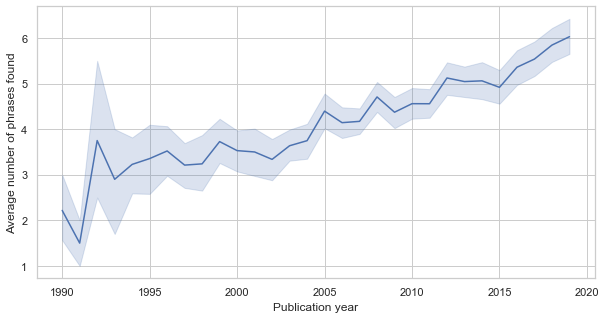

In [18]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plot_df = combined_df.copy()
plot_df.loc[plot_df.loc[:, "Publication year"] < 1990, "Publication year"] = 1990
plot_df.loc[plot_df.loc[:, "Publication year"] > 2019, "Publication year"] = 2019

sns.lineplot(x="Publication year", y="Total number of phrases found", data=plot_df)
plt.ylabel("Average number of phrases found")
plt.show();